In [61]:
import keras.losses
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
from PIL import Image
import cv2

In [2]:
ROOT_DIR = "data"
os.listdir(ROOT_DIR)

['Moderately-differentiate',
 'Normal',
 'Poorly-differentiate',
 'Well-differentiate']

In [3]:
len(os.listdir(ROOT_DIR))

4

In [4]:
# count the number of images in each class
number_of_images = {}

for image_class in os.listdir(ROOT_DIR):
    number_of_images[image_class] = len(os.listdir(os.path.join(ROOT_DIR, image_class)))

number_of_images.items()

dict_items([('Moderately-differentiate', 16), ('Normal', 16), ('Poorly-differentiate', 16), ('Well-differentiate', 17)])

In [9]:
# count the number of images in each class
number_of_images = {}

for image_class in os.listdir('train'):
    number_of_images[image_class] = len(os.listdir(os.path.join('train', image_class)))

number_of_images.items()

dict_items([('Moderately-differentiate', 1055), ('Normal', 1086), ('Poorly-differentiate', 1094), ('Well-differentiate', 998)])

## Preparing the data

In [14]:
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

In [15]:
train_datagen = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, preprocessing_function=preprocess_input, horizontal_flip=True,)
train_images = train_datagen.flow_from_directory(directory='train', target_size=(224, 224),
                                                 batch_size=32, class_mode='categorical')

Found 4233 images belonging to 4 classes.


In [16]:
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_images = validation_datagen.flow_from_directory(directory='val', target_size=(224, 224),
                                                           batch_size=32, class_mode='categorical')

Found 124 images belonging to 4 classes.


In [17]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_images = test_datagen.flow_from_directory(directory='test', target_size=(224, 224),
                                               batch_size=32, class_mode='categorical')

Found 124 images belonging to 4 classes.


# Model Training

In [24]:
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet
from keras.optimizers import Adam

In [18]:
base_model = MobileNet(input_shape=(224,224,3), include_top=False)

17225924/17225924 [==============================] - 20s 1us/step


In [50]:
# Freeze the weights of the first layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [51]:
# Add a new output layer for multiclass classification on top
X = Flatten()(base_model.output)
X = Dense(units=4, activation='softmax')(X)

In [52]:
# Create the new model with the modified layers
model = Model(inputs=base_model.input, outputs=X)

In [53]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [67]:
model.compile(optimizer='rmsprop', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

### Adding Early stopping and Model Checkpoint

In [68]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [79]:
#early stopping
es = EarlyStopping(monitor="accuracy", min_delta=0.01, patience=6, verbose=1, mode='auto', restore_best_weights=True)

# model checkpoint
mc = ModelCheckpoint(monitor="accuracy", filepath="models/transfer_learning/best_model_MobileNet2.h5", save_best_only=True, verbose=1, mode='auto')

cd = [es, mc]

# Model Training

In [80]:
hs = model.fit(train_images,
               epochs=30,
               verbose=1,
               validation_data=validation_images,
               callbacks=cd)

Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 1.9805 - accuracy: 0.8724
Epoch 1: accuracy improved from -inf to 0.87243, saving model to models/transfer_learning\best_model_MobileNet2.h5
133/133 [==============================] - 136s 1s/step - loss: 1.9805 - accuracy: 0.8724 - val_loss: 8.2230 - val_accuracy: 0.6935
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 1.6755 - accuracy: 0.8842
Epoch 2: accuracy improved from 0.87243 to 0.88424, saving model to models/transfer_learning\best_model_MobileNet2.h5
133/133 [==============================] - 133s 1000ms/step - loss: 1.6755 - accuracy: 0.8842 - val_loss: 8.1963 - val_accuracy: 0.7016
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 1.5703 - accuracy: 0.8859
Epoch 3: accuracy improved from 0.88424 to 0.88590, saving model to models/transfer_learning\best_model_MobileNet2.h5
133/133 [==============================] - 135s 1s/step - loss: 1.5703 - accuracy: 0.8859 - v

In [81]:
h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<function matplotlib.pyplot.show(close=None, block=None)>

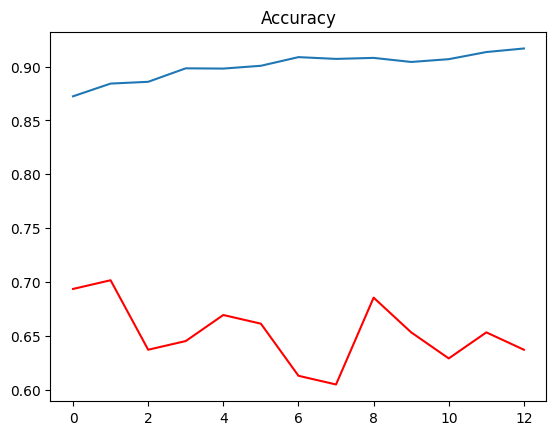

In [82]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c="red")
plt.title('Accuracy')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

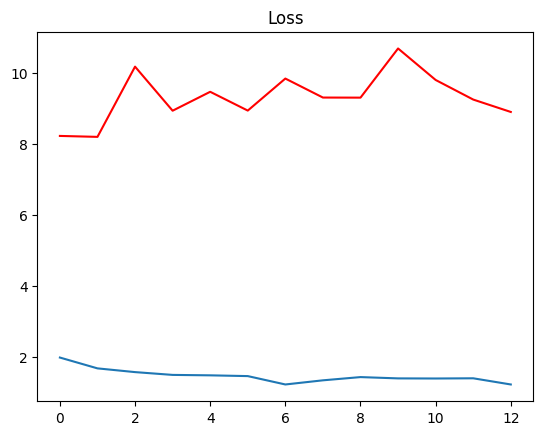

In [83]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c="red")
plt.title('Loss')
plt.show

# Model Accuracy

In [84]:
from keras.models import load_model

model = load_model('models/transfer_learning/best_model_MobileNet2.h5')

In [85]:
acc = model.evaluate(test_images)[1]
print(f"the accuracy of the model is {acc*100} %")

4/4 [==============================] - 6s 1s/step - loss: 12.6892 - accuracy: 0.5565
the accuracy of the model is 55.645161867141724 %
